# Acknowledgements 
This notebook lab has been taken from the TBMI26 course (Neural networks and learning systems).

Examiner: Magnus Borga

Initial code authors (MATLAB version): UNKNOWN

Conversion to Python and overall refinement: Martin Hultman & David Abramian

### **Quick introduction to jupyter notebooks**
* Each cell in this notebook contains either code or text.
* You can run a cell by pressing Ctrl-Enter, or run and advance to the next cell with Shift-Enter.
* Code cells will print their output, including images, below the cell. Running it again deletes the previous output, so be careful if you want to save some results.
* You don't have to rerun all cells to test changes, just rerun the cell you have made changes to. Some exceptions might apply, for example if you overwrite variables from previous cells, but in general this will work.
* If all else fails, use the "Kernel" menu and select "Restart Kernel and Clear All Output". You can also use this menu to run all cells.
* A useful debug tool is the console. You can right-click anywhere in the notebook and select "New console for notebook". This opens a python console which shares the environment with the notebook, which let's you easily print variables or test commands.

### **Setup**

In [3]:
# Automatically reload modules when changed
%reload_ext autoreload
%autoreload 2
# Plot figures "inline" with other output
%matplotlib inline

# Import modules, classes, functions
from matplotlib import pyplot as plt
import numpy as np

from utils import loadDataset, splitData, plotProgress, plotProgressNetworkMulti, \
    plotResultsDots, plotIsolines, plotConfusionMatrixOCR, plotResultsDotsGradient
from evalFunctions import calcAccuracy, calcConfusionMatrix

# Configure nice figures
plt.rcParams['figure.facecolor']='white'
plt.rcParams['figure.figsize']=(8, 5)

### ***! IMPORTANT NOTE !***

Your implementation should only use the `numpy` (`np`) module. The `numpy` module provides all the functionality you need for this assignment and makes it easier debuging your code. No other modules, e.g. `scikit-learn` or `scipy` among others, are allowed. You can find everything you need about `numpy` in the official [documentation](https://numpy.org/doc/stable/).

### **1. Multi-layer neural network**

The implementation of the multi-layer network is a bit beyond the scope of this course, so we will provide it for you. Your task is instead to optimize the training and interpret tthe results.

Similar to the single-layer network, the multi-layer keep track of weight matrices `W1` and `W2`, and bias vectors `B1` and `B2`. The structure of the code is still the same, with a `forward`, `backward`, and `update` function.

#### **1.1 Implementing the forward pass**

This implementation will look similar to the single-layer code, but note that it also returns the intemediate variable `U`, which is the output of the hidden layer after passing throught the activation function. This will be used in the backward pass.

In [7]:
def forward(X, W1, B1, W2, B2, useTanhOutput=False):
    """Forward pass of two layer network

    Args:
        X (array): Input samples.
        W1 (array): First layer neural network weights.
        B1 (array): First layer neural network biases.
        W2 (array): Second layer neural network weights.
        B2 (array): Second layer neural network biases.

    Returns:
        Y (array): Output for each sample and class.
        L (array): Resulting label of each sample.
        U (array): Output of hidden layer.
    """

    # --------------------------------------------
    # === Your code here ========================= 
    # --------------------------------------------

    U = X @ W1 + B1
    U = np.tanh(U)

    Y = U @ W2 + B2

    if useTanhOutput:
        Y = np.tanh(Y)
    
    
    # ============================================
    
    # Calculate labels
    L = Y.argmax(axis=1)

    return Y, L, U

#### **1.2 Implementing the backward pass**

This backward pass implementation uses the so called delta notation. This is very useful when implementing the general case of an N-layer network, since it can easily be implemnted in an iterative manner in a loop going over each layer. We will not do that in this assignment, but it is good to know that this is essentially how the popular frameworks for deep learning functions.

In [9]:
def backward(W1, B1, W2, B2, X, U, Y, D, useTanhOutput=False):
    """Compute the gradients for network weights and biases

    Args:
        W1 (array): Current values of the layer 1 network weights.
        B1 (array): Current values of the layer 1 network biases.
        W2 (array): Current values of the layer 2 network weights.
        B2 (array): Current values of the layer 2 network biases.
        X (array): Training samples.
        U (array): Intermediate outputs of the hidden layer.
        Y (array): Predicted outputs.
        D (array): Target outputs.
        
        useTanhOutput (bool): (optional)
            True  - Network uses tanh activation on output layer
            False - Network uses linear (no) activation on output layer
        
    Returns:
        GradW1 (array): Gradients with respect to W1
        GradB1 (array): Gradients with respect to B1
        GradW2 (array): Gradients with respect to W2
        GradB2 (array): Gradients with respect to B2
    """
    
    N  = Y.shape[0]
    NC = Y.shape[1]
    
    # --------------------------------------------
    # === Your code here =========================
    # --------------------------------------------

    #the gradient of the loss function with respect to the output layer Y
    delta2 = 2/N * (Y-D)
    if useTanhOutput:
        delta2 = delta2 * (1-Y**2)

    #the gradient of the loss function with respect to the hidden layer output 𝑈
    delta1=(delta2 @ W2.T) * (1-U**2)

    # Gradient for the output layer
    GradW2 = U.T @ delta2
    GradB2 = np.sum(delta2, axis=0)

    # And the input layer
    GradW1 = X.T @ delta1
    GradB1 = np.sum(delta1, axis=0)
    
    # ============================================
    
    return GradW1, GradB1, GradW2, GradB2

#### **1.3 Implementing the weight update**

For this update function we have implemented a more powerful algorithm called momentum gradient descent. This is part of an optional task at the end of the notebook, and you do not have to use it unless you want to.

In [11]:
def update(W1, B1, W2, B2, GradW1, GradB1, GradW2, GradB2, params):
    """Update weights and biases using computed gradients.

    Args:
        W1 (array): Current values of the layer 1 network weights.
        B1 (array): Current values of the layer 1 network biases.
        W2 (array): Current values of the layer 2 network weights.
        B2 (array): Current values of the layer 2 network biases.
        
        GradW1 (array): Gradients with respect to W1.
        GradB1 (array): Gradients with respect to B1.
        GradW2 (array): Gradients with respect to W2.
        GradB2 (array): Gradients with respect to B2.
        
        params (dict):
            - learningRate: Scale factor for update step.
            - momentum: Scale factor for momentum update (optional).
        
    Returns:
        W1 (array): Updated layer 1 weights.
        B1 (array): Updated layer 1 biases.
        W2 (array): Updated layer 2 weights.
        B2 (array): Updated layer 2 biases.
    """
    
    LR = params["learningRate"]
    
    # Uncomment this is you are working on the optional task on momentum.
    # M = params["momentum"]
    # PrevGradW1 = params["PrevGradW1"]
    # PrevGradB1 = params["PrevGradB1"]
    # PrevGradW2 = params["PrevGradW2"]
    # PrevGradB2 = params["PrevGradB2"]
    
    # --------------------------------------------
    # === Your code here =========================
    # --------------------------------------------
    
    # Update weights
    W1 = W1 - GradW1*LR
    B1 = B1 - GradB1*LR
    W2 = W2 - GradW2*LR
    B2 = B2 - GradB2*LR
        
    # ============================================
    
    return W1, B1, W2, B2
    

#### **1.4 The training function**

In [13]:
def trainMultiLayer(XTrain, DTrain, XTest, DTest, W1_0, B1_0, W2_0, B2_0, params):
    """Trains a two-layer network

    Args:
        XTrain (array): Training samples.
        DTrain (array): Training network target values.
        XTest (array): Test samples.
        DTest (array): Test network target values.
        W1_0 (array): Initial values of the first layer network weights.
        B1_0 (array): Initial values of the first layer network biases.
        W2_0 (array): Initial values of the second layer network weights.
        B2_0 (array): Initial values of the second layer network biases.
        params (dict): Dictionary containing:
            epochs (int): Number of training steps.
            learningRate (float): Size of a training step.

    Returns:
        W1 (array): First layer weights after training.
        B1 (array): Fisrt layer biases after training.
        W2 (array): Second layer weights after training.
        B2 (array): Second layer biases after training.
        metrics (dict): Losses and accuracies for training and test data.
    """

    # Initialize variables
    metrics = {keys:np.zeros(params["epochs"]+1) for keys in ["lossTrain", "lossTest", "accTrain", "accTest"]}

    if "useTanhOutput" not in params:
        params["useTanhOutput"] = False
        
    if "momentum" not in params:
        params["momentum"] = 0       
    
    nTrain = XTrain.shape[0]
    nTest  = XTest.shape[0]
    nClasses = DTrain.shape[1]
    
    # Set initial weights
    W1 = W1_0
    B1 = B1_0
    W2 = W2_0
    B2 = B2_0
    
    # For optional task on momentum
    params["PrevGradW1"] = np.zeros_like(W1)
    params["PrevGradB1"] = np.zeros_like(B1)
    params["PrevGradW2"] = np.zeros_like(W2)
    params["PrevGradB2"] = np.zeros_like(B2)

    # Get class labels
    LTrain = np.argmax(DTrain, axis=1)
    LTest  = np.argmax(DTest , axis=1)

    # Calculate initial metrics
    YTrain, LTrainPred, UTrain = forward(XTrain, W1, B1, W2, B2, params["useTanhOutput"])
    YTest , LTestPred , _      = forward(XTest , W1, B1, W2, B2, params["useTanhOutput"])
    
    # Including the initial metrics makes the progress plots worse, set nan to exclude
    metrics["lossTrain"][0] = np.nan # ((YTrain - DTrain)**2).mean()
    metrics["lossTest"][0]  = np.nan # ((YTest  - DTest )**2).mean()
    metrics["accTrain"][0]  = np.nan # (LTrainPred == LTrain).mean()
    metrics["accTest"][0]   = np.nan # (LTestPred  == LTest ).mean()

    # Create figure for plotting progress
    fig = plt.figure(figsize=(20,8), tight_layout=True)

    # Training loop
    for n in range(1, params["epochs"]+1):
        
        # --------------------------------------------
        # === This is the important part =============
        # === where your code is applied =============
        # --------------------------------------------
        
        # Compute gradients...
        GradW1, GradB1, GradW2, GradB2 = backward(W1, B1, W2, B2, XTrain, UTrain, YTrain, DTrain, params["useTanhOutput"])
        # ... and update weights
        W1, B1, W2, B2 = update(W1, B1, W2, B2, GradW1, GradB1, GradW2, GradB2, params)
        
        # ============================================
        
        # Evaluate errors
        YTrain, LTrainPred, UTrain = forward(XTrain, W1, B1, W2, B2, params["useTanhOutput"])
        YTest , LTestPred , _      = forward(XTest , W1, B1, W2, B2, params["useTanhOutput"])
        metrics["lossTrain"][n] = ((YTrain - DTrain)**2).mean()
        metrics["lossTest"][n]  = ((YTest  - DTest )**2).mean()
        metrics["accTrain"][n]  = (LTrainPred == LTrain).mean()
        metrics["accTest"][n]   = (LTestPred  == LTest ).mean()

        # Plot progress
        if (plotProgress and not n % 500) or n == params["epochs"]:
            if W1.shape[0] == 2 and W1.shape[1] <= 8:
                plotProgressNetworkMulti(fig, W1, B1, W2, B2, metrics, n=n)
            else:
                plotProgress(fig, metrics, n)

    return W1, B1, W2, B2, metrics

We also define the same function for normalizing the data, which is even more important now that we have more than one layer.

In [15]:
def normalize(X):
    # Compute mean and std
    m = X.mean(axis=0)
    s = X.std(axis=0)
    # Prevent division by 0 is feature has no variance
    s[s == 0] = 1
    # Return normalized data
    return (X - m) / s

#### **<span style="color:red">Question</span>**

1. Explain why large, non-normalized input features might be a problem when using two layers, but not when using a single layer.

#### **<span style="color:green">Answer:</span>**

When using large, non-normalized input features, the main issue arises due to the way weights and activations propagate through multiple layers in a neural network.

In a single-layer network, if the input features $x$ are large, the learned weights $W_1$ can adjust accordingly, and since there's no further transformation, the impact of large values remains manageable.

In a two-layer network, if $x$ has large, non-normalized values, the output $h$ of the first layer can also become very large. This can cause issues such as exploding activations, in which, if we use activation functions like ReLU, large inputs can lead to disproportionately high outputs in deeper layers, making learning unstable. Or also, saturation of activations, that in case of sigmoidal activations, large inputs push activations to their asymptotic limits, leading to vanishing gradients and slowing down learning. Then, the second layer then has to work with these extreme values, which can make weight updates inefficient and cause poor convergence.

---
### **2 Optimizing each dataset**

Like before, we define a function that performs the boilerplate code for training the networks.

In [19]:
def  trainMultiLayerOnDataset(datasetNr, testSplit, W1_0, B1_0, W2_0, B2_0, params):
    """Train a two layer network on a specific dataset.

    Ags:
        datasetNr (int): ID of dataset to use
        testSplit (float): Fraction of data reserved for testing.
        W1_0 (array): Initial values of the first layer network weights.
        B1_0 (array): Initial values of the first layer network biases.
        W2_0 (array): Initial values of the second layer network weights.
        B2_0 (array): Initial values of the second layer network biases.
        params (dict): Dictionary containing:
            nIterations (int): Number of training steps.
            learningRate (float): Size of a training step.
    """
    
    # Load data and split into training and test sets
    X, D, L = loadDataset(datasetNr)
    XTrain, DTrain, LTrain, XTest, DTest, LTest = splitData(X, D, L, testSplit)
    
    if "normalize" in params and params["normalize"]:
        XTrainNorm = normalize(XTrain)
        XTestNorm  = normalize(XTest)
    else:
        XTrainNorm = XTrain
        XTestNorm  = XTest

    # Train network
    W1, B1, W2, B2, metrics = trainMultiLayer(XTrainNorm, DTrain, XTestNorm, DTest, W1_0, B1_0, W2_0, B2_0, params)

    # Predict classes on test set
    LPredTrain = forward(XTrainNorm, W1, B1, W2, B2, params["useTanhOutput"])[1]
    LPredTest  = forward(XTestNorm , W1, B1, W2, B2, params["useTanhOutput"])[1]

    # Compute metrics
    accTrain = calcAccuracy(LPredTrain, LTrain)
    accTest  = calcAccuracy(LPredTest , LTest)
    confMatrix = calcConfusionMatrix(LPredTest, LTest)

    # Display results
    print(f'Train accuracy: {accTrain:.4f}')
    print(f'Test accuracy: {accTest:.4f}')
    print("Test data confusion matrix:")
    print(confMatrix)

    if datasetNr < 4:
        # Switch between these two functions to see another way to visualize the network output.
        plotResultsDots(XTrainNorm, LTrain, LPredTrain, XTestNorm, LTest, LPredTest, lambda X: forward(X, W1, B1, W2, B2, params["useTanhOutput"])[1])
        #plotResultsDotsGradient(XTrainNorm, LTrain, LPredTrain, XTestNorm, LTest, LPredTest, lambda X: forward(X, W1, B1, W2, B2, params["useTanhOutput"])[0])
    else:
        plotConfusionMatrixOCR(XTest, LTest, LPredTest)

#### **2.1 Optimizing dataset 1**

Train accuracy: 0.9912
Test accuracy: 0.9900
Test data confusion matrix:
[[150.   3.]
 [  0. 147.]]


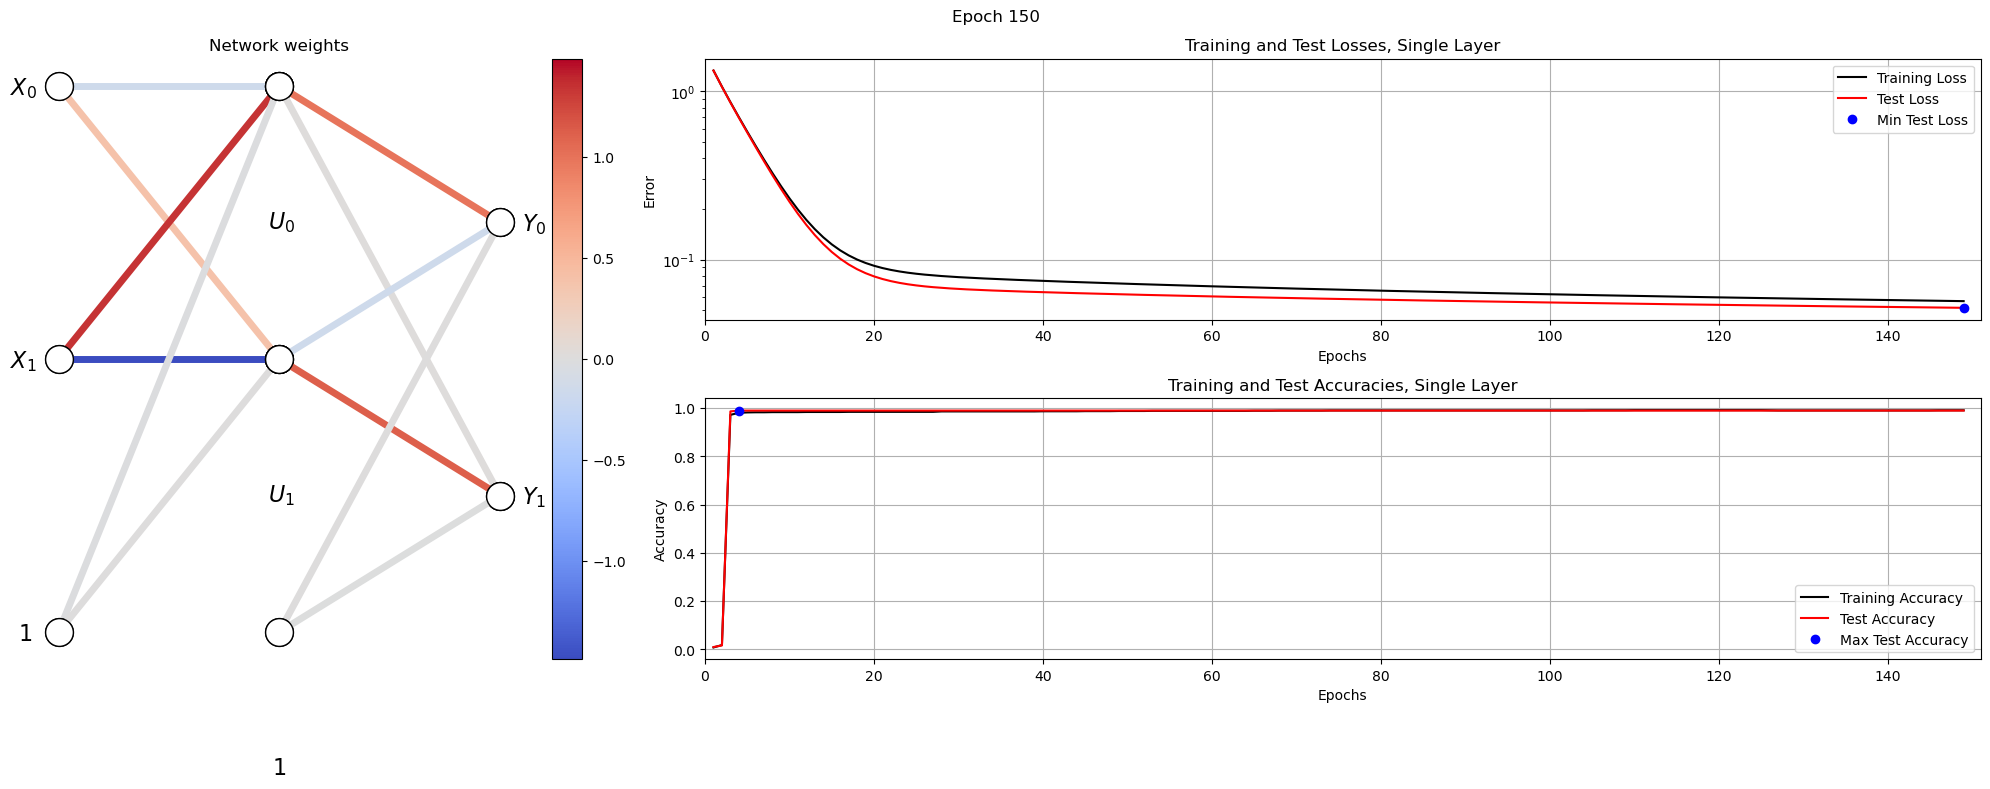

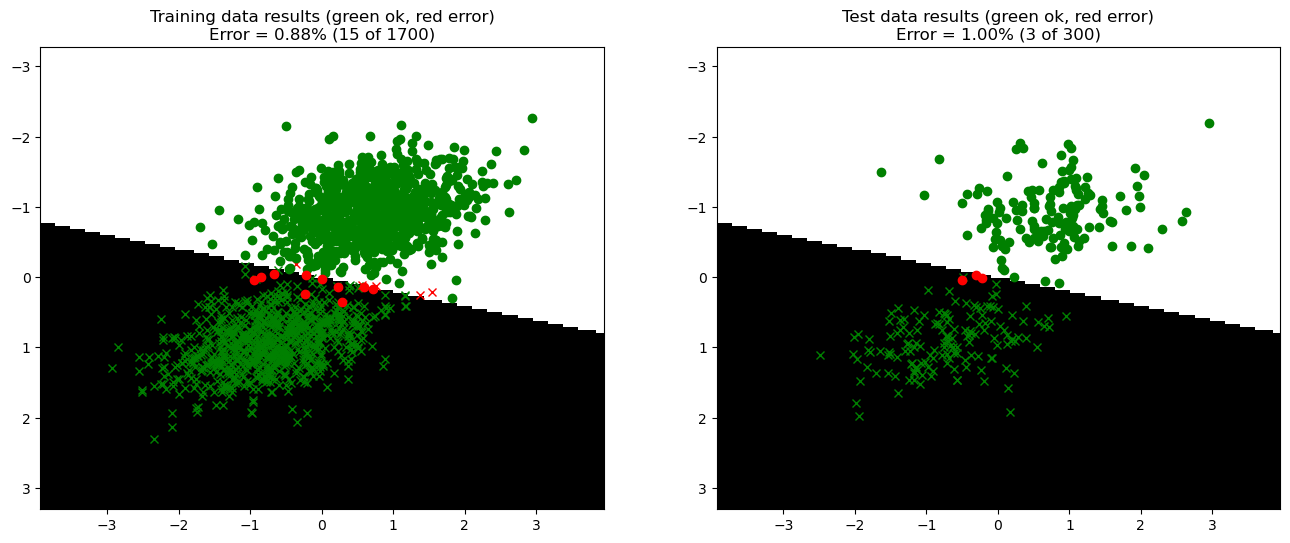

In [21]:
# --------------------------------------------
# === Your code here ========================= 
# --------------------------------------------
datasetNr = 1
X, D, L = loadDataset(datasetNr)

nInputs  = X.shape[1]
nClasses = len(np.unique(L))
nHidden = 2

W1_0 = np.random.uniform(-1, 1, size = (nInputs, nHidden)) * np.sqrt(6/(nInputs + nHidden))
B1_0 = np.zeros((1, nHidden))
W2_0 = np.random.uniform(-1, 1, size = (nHidden, nClasses)) * np.sqrt(6/(nInputs + nClasses))
B2_0 = np.zeros((1, nClasses))

params = {"epochs": 150, "learningRate": 0.05, "normalize": True, "useTanhOutput": False}
# ============================================

trainMultiLayerOnDataset(1, 0.15, W1_0, B1_0, W2_0, B2_0, params)

#### **<span style="color:red">Question:</span>**

2. Optimize the training until you reach at least 98% test accuracy. Briefly motivate your choice of hyperparameters.

#### **<span style="color:green">Answer:</span>**

`nHidden` = 3: Increasing the number of hidden neurons beyond 3 did not improve accuracy, so keeping it at 3 was a reasonable choice to avoid unnecessary complexity.

`epochs` = 150: Initially set to 200, but since the maximum test accuracy was reached before 150 epochs, we reduced it to 150. This prevents unnecessary computations and reduces the risk of overfitting.

`learnningRate` = 0.05: The test accuracy improved smoothly without oscillations, indicating a stable and effective learning process.

`normalize` = TRUE: Normalization ensures that all features contribute proportionally to the gradient, preventing any single feature from dominating the optimization process. This improves model stability and speeds up convergence.

`useTanhOutput` = FALSE: The Tanh is more suitable for regression tasks with outputs in a limited range, rather than for classification.

#### **2.2 Optimizing dataset 2**

Train accuracy: 0.9918
Test accuracy: 0.9967
Test data confusion matrix:
[[140.   0.]
 [  1. 159.]]


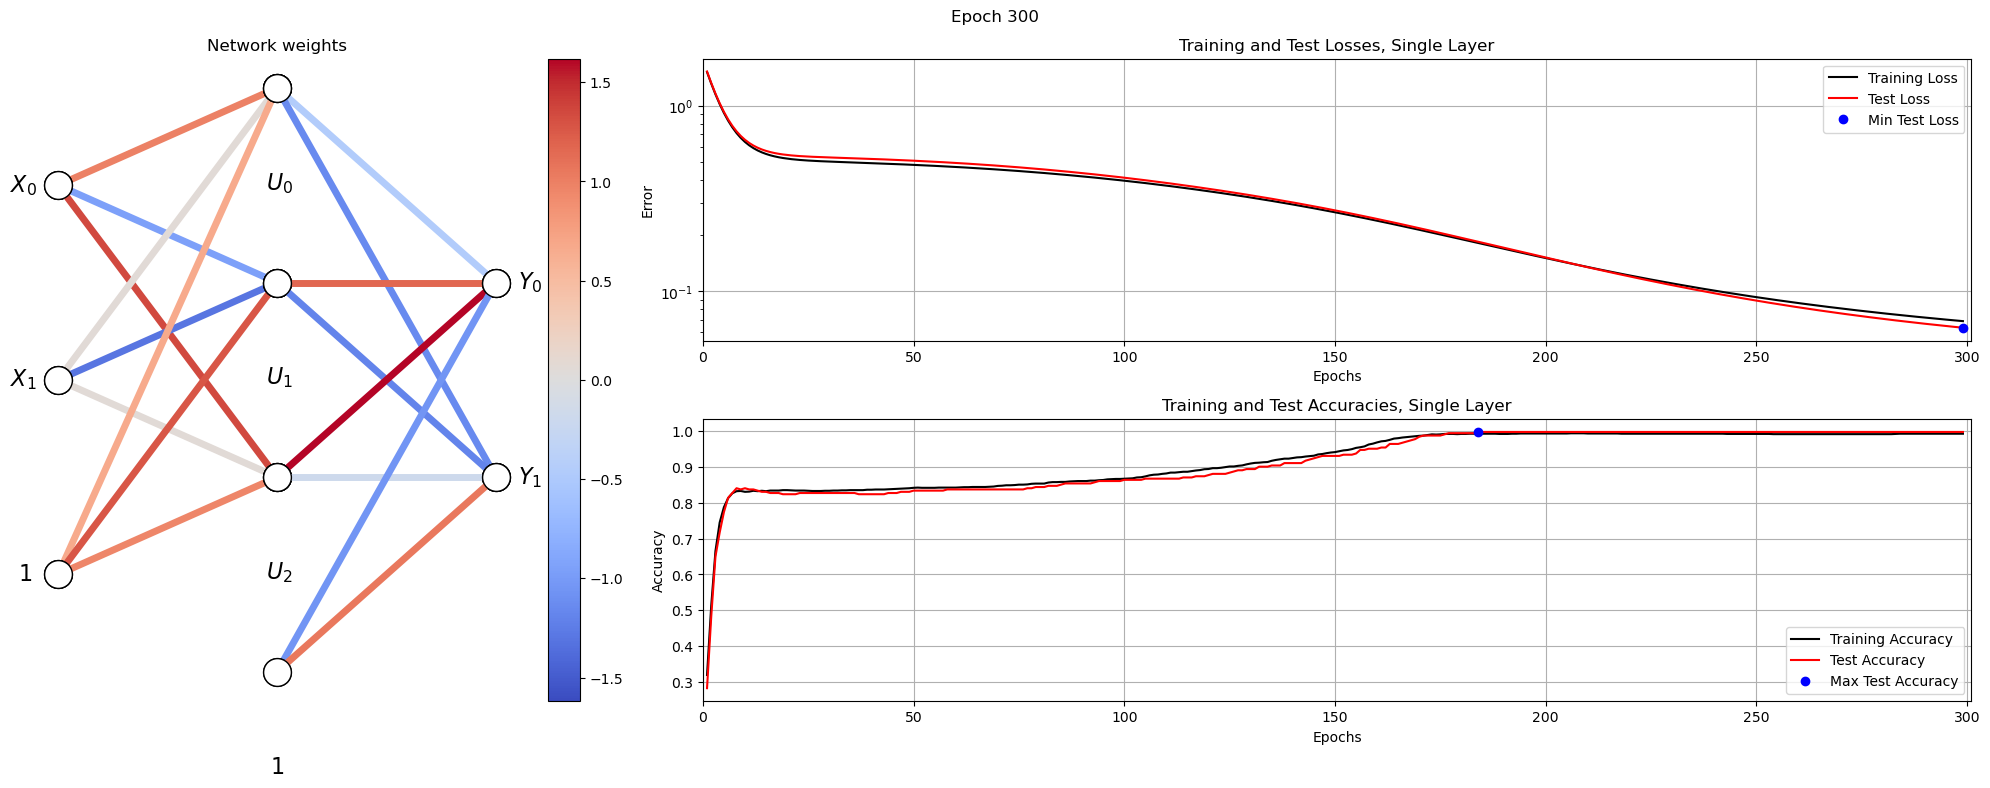

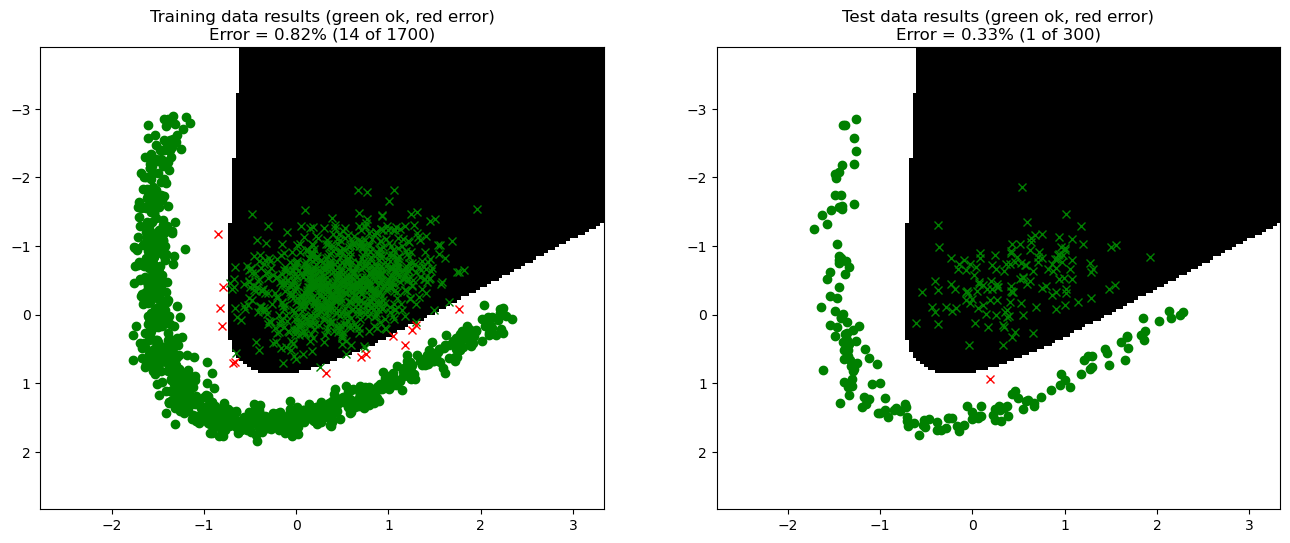

In [24]:
# --------------------------------------------
# === Your code here ========================= 
# --------------------------------------------
datasetNr = 2
X, D, L = loadDataset(datasetNr)

nInputs  = X.shape[1]
nClasses = len(np.unique(L))
nHidden = 3

W1_0 = np.random.uniform(-1, 1, size = (nInputs, nHidden)) * np.sqrt(6/(nInputs + nHidden))
B1_0 = np.zeros((1, nHidden))
W2_0 = np.random.uniform(-1, 1, size = (nHidden, nClasses)) * np.sqrt(6/(nInputs + nClasses))
B2_0 = np.zeros((1, nClasses))

params = {"epochs": 300, "learningRate": 0.05, "normalize": True, "useTanhOutput": False}
# ============================================

trainMultiLayerOnDataset(2, 0.15, W1_0, B1_0, W2_0, B2_0, params)

#### **<span style="color:red">Question:</span>**

3. Optimize the training until you reach at least 99% test accuracy. Briefly motivate your choice of hyperparameters.

#### **<span style="color:green">Answer:</span>**

`nHidden` = 3: Increasing the number of hidden neurons beyond 3 did not lead to further accuracy improvements, so keeping it at 3 balances model complexity and generalization.

`epochs` = 300: Initially set higher, but test accuracy continued improving until close to 300 epochs, justifying this choice. A higher epoch count ensures the model fully learns the patterns in the data without premature stopping.

`learnningRate` = 0.05: The model reached high test accuracy without oscillations, indicating that this learning rate provides a good balance between convergence speed and stability.

`normalize` = TRUE: Normalization ensures that all input features contribute proportionally, preventing numerical instability and helping the optimization process converge more efficiently.

`useTanhOutput` = FALSE: Not using the Tanh activation function in the output layer led to good results, so it was left out.

#### **2.3 Optimizing dataset 3**

Train accuracy: 0.9965
Test accuracy: 0.9967
Test data confusion matrix:
[[ 96.   0.   0.]
 [  1. 109.   0.]
 [  0.   0.  94.]]


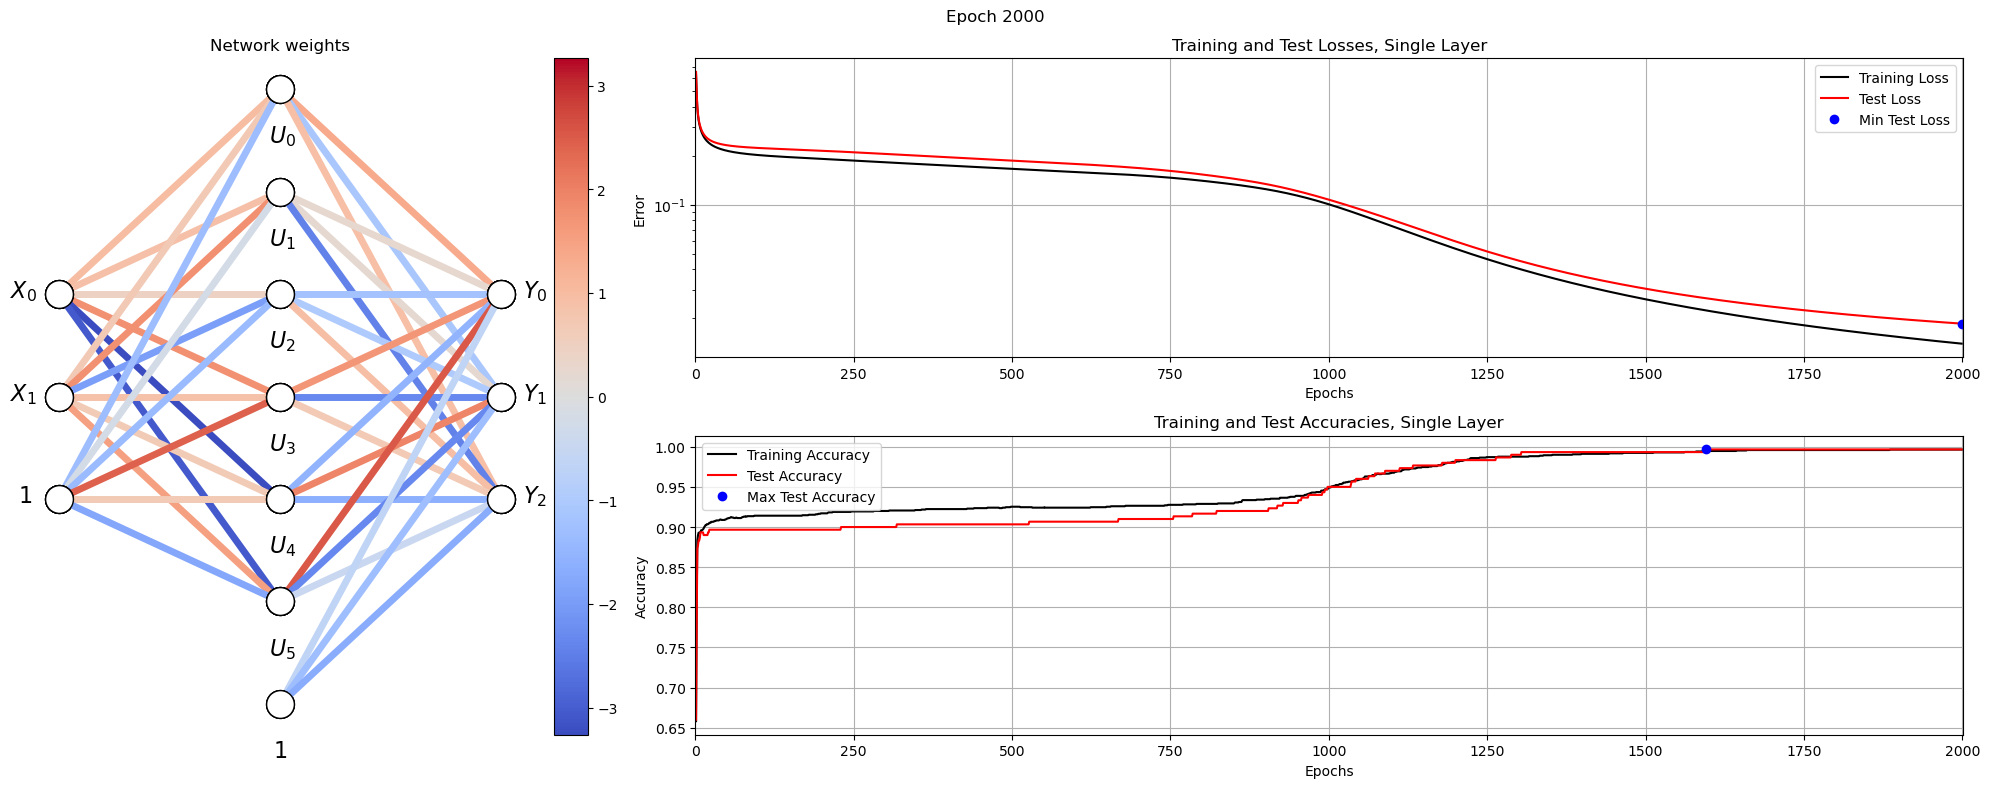

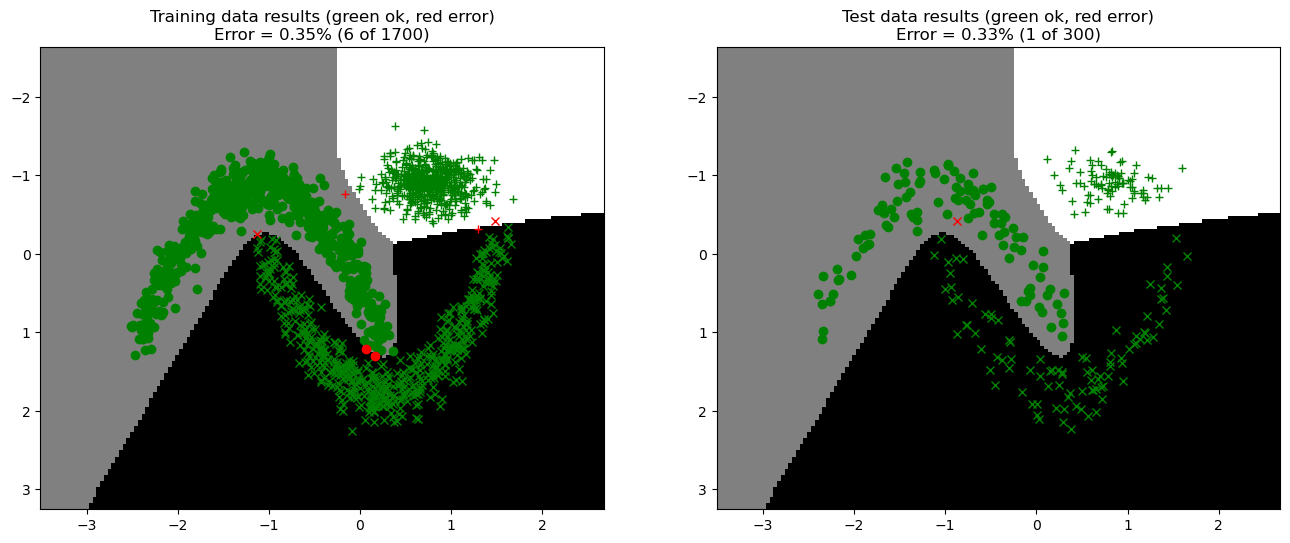

In [27]:
# --------------------------------------------
# === Your code here ========================= 
# --------------------------------------------
datasetNr = 3
X, D, L = loadDataset(datasetNr)

nInputs  = X.shape[1]
nClasses = len(np.unique(L))
nHidden = 6

W1_0 = np.random.uniform(-1, 1, size = (nInputs, nHidden)) * np.sqrt(6/(nInputs + nHidden))
B1_0 = np.zeros((1, nHidden))
W2_0 = np.random.uniform(-1, 1, size = (nHidden, nClasses)) * np.sqrt(6/(nInputs + nClasses))
B2_0 = np.zeros((1, nClasses))

params = {"epochs": 2000, "learningRate": 0.1, "normalize": True, "useTanhOutput": True}
# ============================================

trainMultiLayerOnDataset(3, 0.15, W1_0, B1_0, W2_0, B2_0, params)

#### **<span style="color:red">Question:</span>**

4. Optimize the training until you reach at least 99% test accuracy. Briefly motivate your choice of hyperparameters.

#### **<span style="color:green">Answer:</span>**

`nHidden` = 6: A higher number of hidden neurons was necessary to capture the complexity of the dataset. Increasing beyond 6 did not significantly improve accuracy, making this a balanced choice between capacity and efficiency.

`epochs` = 2000: The model required a larger number of training iterations to fully converge. Test accuracy continued improving throughout training, justifying the need for 2000 epochs to ensure optimal learning.

`learnningRate` = 0.1: A higher learning rate allowed the model to converge faster without instability or significant oscillations, making training more efficient.

`normalize` = TRUE: Normalization ensured that all input features contributed proportionally to the gradient, preventing large-scale features from dominating the learning process. This improved stability and helped the model converge more effectively.

`useTanhOutput` = TRUE: Using the Tanh activation function for the output layer ensures more efficient outputs.

#### **2.4 Optimizing dataset 4**

Train accuracy: 0.9927
Test accuracy: 0.9692
Test data confusion matrix:
[[98.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 80.  0.  0.  0.  0.  0.  0.  2.  2.]
 [ 0.  0. 73.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 86.  0.  0.  0.  1.  0.  0.]
 [ 2.  0.  0.  0. 76.  0.  2.  0.  0.  2.]
 [ 0.  0.  0.  2.  0. 77.  0.  0.  0.  3.]
 [ 0.  0.  0.  0.  1.  0. 80.  0.  0.  0.]
 [ 0.  0.  0.  2.  0.  0.  0. 84.  0.  0.]
 [ 0.  3.  0.  0.  0.  0.  0.  0. 77.  3.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0. 86.]]


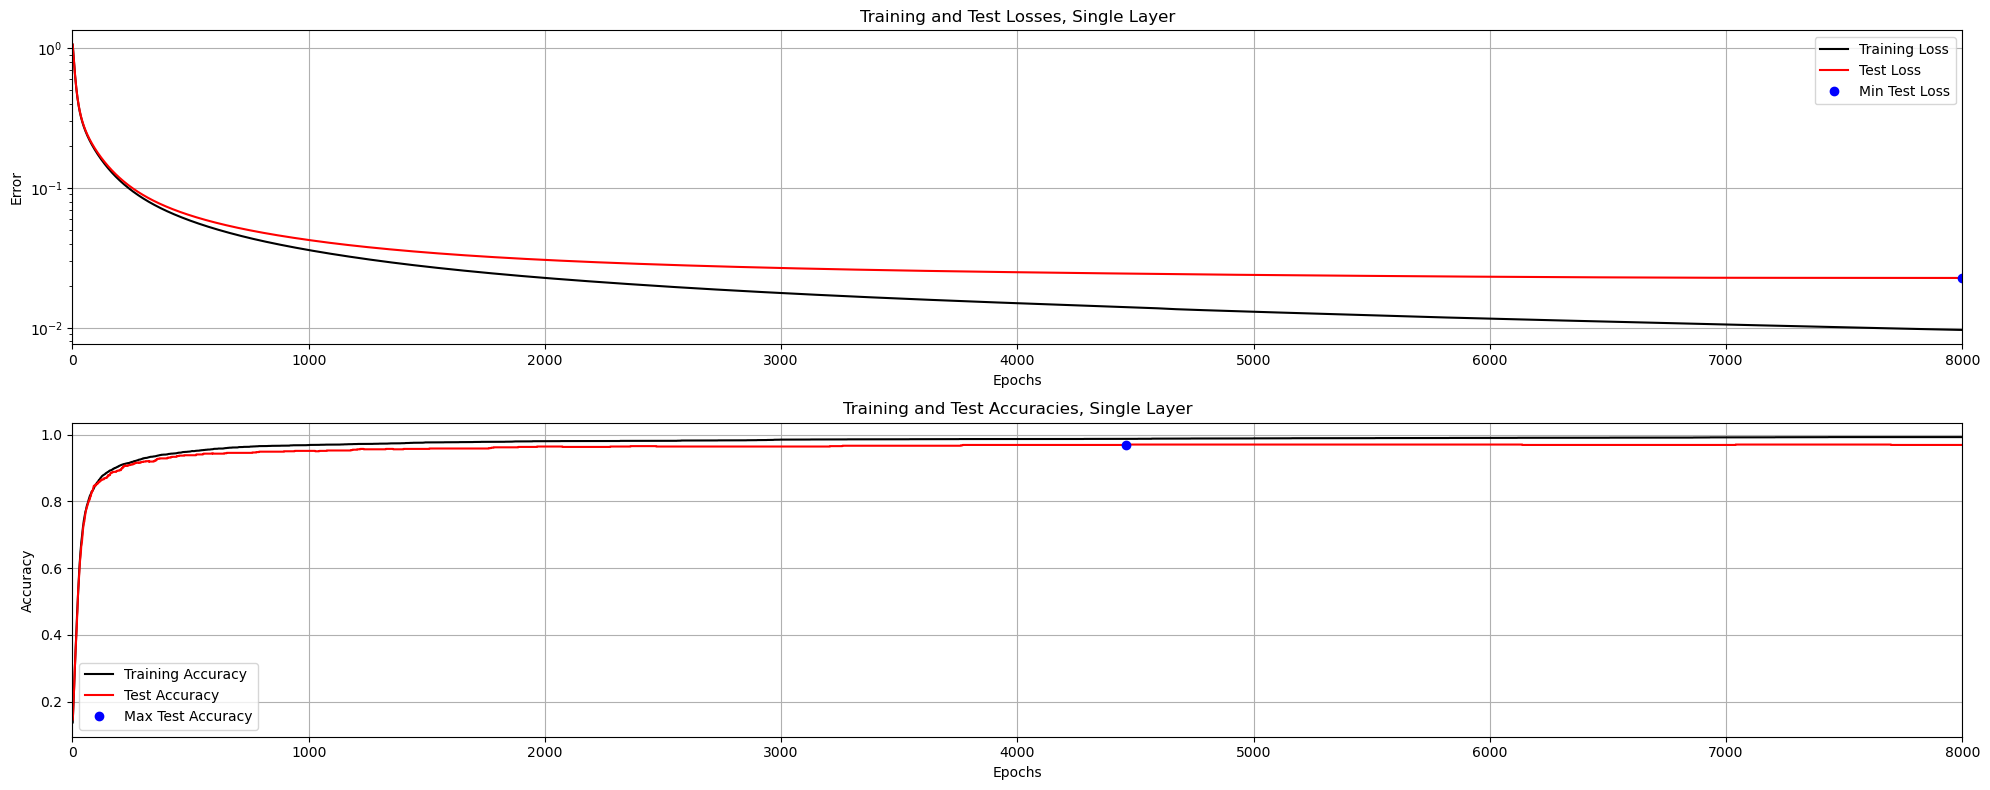

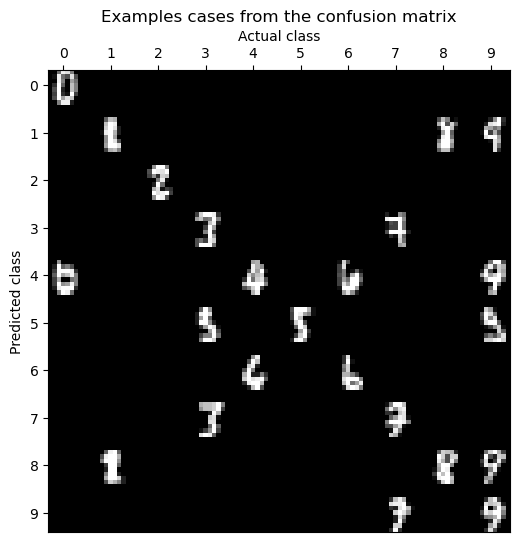

In [30]:
# --------------------------------------------
# === Your code here ========================= 
# --------------------------------------------
datasetNr = 4
X, D, L = loadDataset(datasetNr)

nInputs  = X.shape[1]
nClasses = len(np.unique(L))
nHidden = 15

W1_0 = np.random.uniform(-1, 1, size = (nInputs, nHidden)) * np.sqrt(6/(nInputs + nHidden))
B1_0 = np.zeros((1, nHidden))
W2_0 = np.random.uniform(-1, 1, size = (nHidden, nClasses)) * np.sqrt(6/(nInputs + nClasses))
B2_0 = np.zeros((1, nClasses))

params = {"epochs": 8000, "learningRate": 0.02, "normalize": True, "useTanhOutput": True}
# ============================================

trainMultiLayerOnDataset(4, 0.15, W1_0, B1_0, W2_0, B2_0, params)

#### **<span style="color:red">Question:</span>**

5. Optimize the training until you reach at least 96% test accuracy. Briefly motivate your choice of hyperparameters.

#### **<span style="color:green">Answer:</span>**

`nHidden` = 15: The OCR dataset is significantly more complex than the previous ones, requiring a larger number of hidden neurons to capture intricate patterns in handwritten digits. Increasing to 15 hidden neurons allows the model to learn more detailed representations without excessive overfitting.

`epochs` = 8000: Handwritten digit recognition involves subtle variations in shapes, requiring a longer training period. The model needs more iterations to converge properly and extract meaningful features from the 8×8 pixel images. Empirical testing showed that accuracy continued improving over many epochs, justifying the high epoch count.

`learnningRate` = 0.02: A lower learning rate is beneficial for OCR tasks to ensure stable convergence. Given the complexity of the dataset, a learning rate of 0.02 prevents large weight updates that could cause instability while still allowing steady improvement.

`normalize` = TRUE:  Normalization is crucial for OCR data since pixel intensities can vary significantly. Without normalization, large intensity differences between pixels could dominate the learning process, making it harder to converge. By normalizing, the model learns more balanced feature representations.

`useTanhOutput` = TRUE: It enables the model to learn complex patterns beyond simple linear separations. It also helps avoid issues with large weight updates, making training more stable.